# Clay Tryon
# Final Project, AI 240
# =============================================

## The purpose of this project is to analyze the global impact of COVID-19 using country-level statistics. I aim to implement a Decision Tree to predict which countries had a high fatality rate during the pandemic, based on features such as total confirmed cases, active cases, new cases, and recovery ratios. This will help highlight which factors were most associated with severe national-level outcomes.

## The dataset can be found at:
https://www.kaggle.com/datasets/imdevskp/corona-virus-report


## Step 1, import all modules

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier


## Step 2, Gather the dataset and it's features

In [29]:
filepath = 'country_wise_latest.csv'
raw_df= pd.read_csv(filepath)
raw_df.head(50)

,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region
0,Afghanistan,36263,1269,25198,9796,106,10,18,3.50,69.49,5.04,35526,737,2.07,Eastern Mediterranean
1,Albania,4880,144,2745,1991,117,6,63,2.95,56.25,5.25,4171,709,17.00,Europe
2,Algeria,27973,1163,18837,7973,616,8,749,4.16,67.34,6.17,23691,4282,18.07,Africa
3,Andorra,907,52,803,52,10,0,0,5.73,88.53,6.48,884,23,2.60,Europe
4,Angola,950,41,242,667,18,1,0,4.32,25.47,16.94,749,201,26.84,Africa
5,Antigua and Barbuda,86,3,65,18,4,0,5,3.49,75.58,4.62,76,10,13.16,Americas
6,Argentina,167416,3059,72575,91782,4890,120,2057,1.83,43.35,4.21,130774,36642,28.02,Americas
7,Armenia,37390,711,26665,10014,73,6,187,1.90,71.32,2.67,34981,2409,6.89,Europe
8,Australia,15303,167,9311,5825,368,6,137,1.09,60.84,1.79,12428,2875,23.13,Western Pacific
9,Austria,20558,713,18246,1599,86,1,37,3.47,88.75,3.91,19743,815,4.13,Europe


## Step 3 and 4, Analyze the dataset features, and do basic visualization. Cleaning the data


In [30]:
# This table does not include a given value for a high fatality rate. This is effectively what our Deaths/100 cases reflects
# I will use this to add a column for whether it is a high rate or not. Globally, the CFR for Covid was considered 4%, so we will deem anything above 4% 
# to be a high fatality
# Once I have this column added, I will drop the Deaths/ 100 cases column as well, otherwise our model will just read that instead of looking at other factors

#Check for unique values
raw_df.nunique()

Country/Region            187
Confirmed                 184
Deaths                    150
Recovered                 178
Active                    173
New cases                 122
New deaths                 38
New recovered             103
Deaths / 100 Cases        145
Recovered / 100 Cases     177
Deaths / 100 Recovered    155
Confirmed last week       183
1 week change             162
1 week % increase         169
WHO Region                  6
dtype: int64

In [31]:
# Most of these features do not help our existing data. Country/Region is just an identifier and doesn't give predictive value.
# Deaths per 100/Cases is our target, so we leave this
# Deaths per 100 recovered is very close to our target, but doesn't give much predictive value. 
# WHO region needs to be encoded to numerical values, but I think the information is still highly pertinent as healthcare in Europe vs Africa are starkly different


raw_df['HighFatality'] = raw_df['Deaths / 100 Cases']>=4

raw_df.head()

,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region,HighFatality
0,Afghanistan,36263,1269,25198,9796,106,10,18,3.50,69.49,5.04,35526,737,2.07,Eastern Mediterranean,False
1,Albania,4880,144,2745,1991,117,6,63,2.95,56.25,5.25,4171,709,17.00,Europe,False
2,Algeria,27973,1163,18837,7973,616,8,749,4.16,67.34,6.17,23691,4282,18.07,Africa,True
3,Andorra,907,52,803,52,10,0,0,5.73,88.53,6.48,884,23,2.60,Europe,True
4,Angola,950,41,242,667,18,1,0,4.32,25.47,16.94,749,201,26.84,Africa,True


In [32]:
# Drop the unnecessary columns. Country/Region, Deaths per 100 recovered. Everything else is relevant
raw_df = raw_df.drop(['Country/Region', 'Deaths / 100 Recovered', 'Deaths / 100 Cases'], axis=1)
raw_df.head()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Recovered / 100 Cases,Confirmed last week,1 week change,1 week % increase,WHO Region,HighFatality
0,36263,1269,25198,9796,106,10,18,69.49,35526,737,2.07,Eastern Mediterranean,False
1,4880,144,2745,1991,117,6,63,56.25,4171,709,17.00,Europe,False
2,27973,1163,18837,7973,616,8,749,67.34,23691,4282,18.07,Africa,True
3,907,52,803,52,10,0,0,88.53,884,23,2.60,Europe,True
4,950,41,242,667,18,1,0,25.47,749,201,26.84,Africa,True


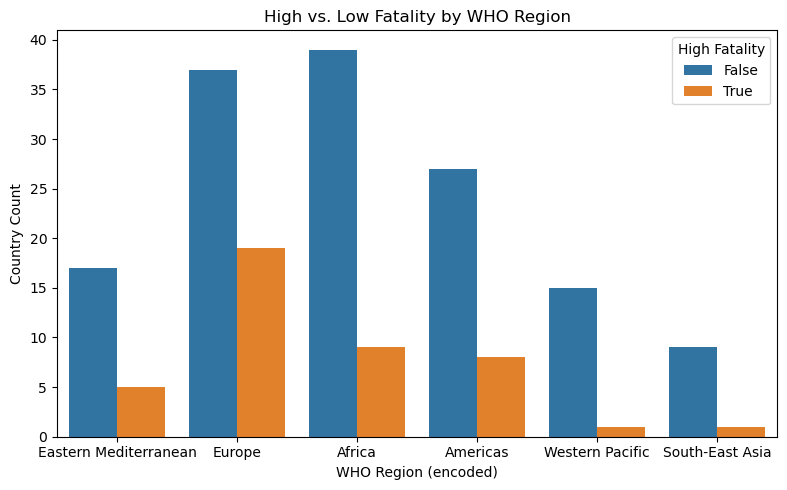

In [33]:
# Preliminary data graphs to check for trends before modeling

# List of features to visualize
features_to_plot = features_to_plot = raw_df.drop('HighFatality', axis=1).columns


# Loop through numeric features and plot against Confirmed or Deaths
import seaborn as sns
import matplotlib.pyplot as plt

# Barplot of HighFatality counts per WHO Region
plt.figure(figsize=(8, 5))
sns.countplot(data=raw_df, x='WHO Region', hue='HighFatality')
plt.title("High vs. Low Fatality by WHO Region")
plt.xlabel("WHO Region (encoded)")
plt.ylabel("Country Count")
plt.legend(title="High Fatality")
plt.tight_layout()
plt.show()




In [34]:
# Now that we've done basic visualization by region, we can encode our values to numbers
# I need to convert WHO region and HighFatality into encoded values and not strings

le = LabelEncoder()
raw_df['WHO Region'] = le.fit_transform(raw_df['WHO Region'])
raw_df['HighFatality'] = le.fit_transform(raw_df['HighFatality'])
raw_df.head()


,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Recovered / 100 Cases,Confirmed last week,1 week change,1 week % increase,WHO Region,HighFatality
0,36263,1269,25198,9796,106,10,18,69.49,35526,737,2.07,2,0
1,4880,144,2745,1991,117,6,63,56.25,4171,709,17.00,3,0
2,27973,1163,18837,7973,616,8,749,67.34,23691,4282,18.07,0,1
3,907,52,803,52,10,0,0,88.53,884,23,2.60,3,1
4,950,41,242,667,18,1,0,25.47,749,201,26.84,0,1


In [35]:
raw_df.head()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Recovered / 100 Cases,Confirmed last week,1 week change,1 week % increase,WHO Region,HighFatality
0,36263,1269,25198,9796,106,10,18,69.49,35526,737,2.07,2,0
1,4880,144,2745,1991,117,6,63,56.25,4171,709,17.00,3,0
2,27973,1163,18837,7973,616,8,749,67.34,23691,4282,18.07,0,1
3,907,52,803,52,10,0,0,88.53,884,23,2.60,3,1
4,950,41,242,667,18,1,0,25.47,749,201,26.84,0,1


In [36]:
print(raw_df.dtypes)

Confirmed                  int64
Deaths                     int64
Recovered                  int64
Active                     int64
New cases                  int64
New deaths                 int64
New recovered              int64
Recovered / 100 Cases    float64
Confirmed last week        int64
1 week change              int64
1 week % increase        float64
WHO Region                 int32
HighFatality               int64
dtype: object


In [37]:
df = raw_df

## Last Step Modeling: Implementing and evaluating machine learning model 


In [38]:
# Define features and target
X = df.drop('HighFatality', axis=1)
y = df['HighFatality']

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [39]:
# I want this model to be as good as possible. As such, I looked into hyperparameter training and implemented this to check my 
# decision tree values. I opted to aim for a high F1 score in this hyperparameter tuning, as with the small dataset and training information available,
# It would be hard to get recall, accuracy, and Perception to all train well


# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight' : [None, 'balanced']
}


# Set up the base model
tree_model = DecisionTreeClassifier(random_state=0)

# Set up the grid search
grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='f1')

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model and parameters
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 10}


In [40]:
model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    min_samples_split=10,
    random_state=0
)

model.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=10,
                       random_state=0)

In [41]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.7631578947368421


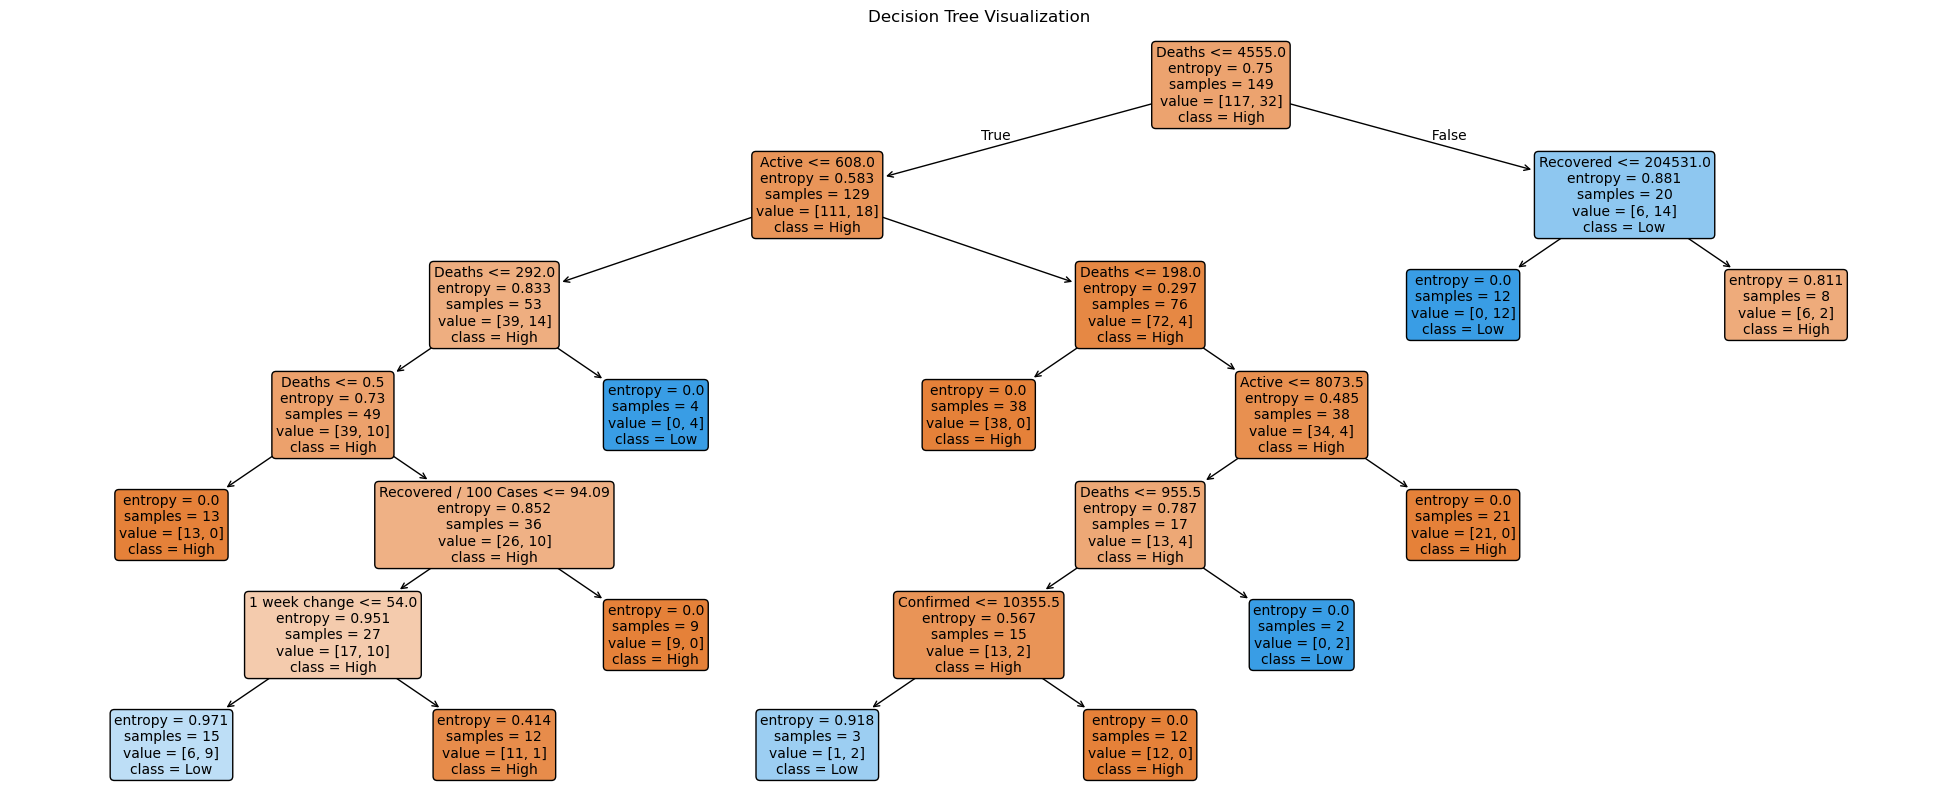

In [42]:
plt.figure(figsize=(25, 10))  # Adjust size as needed
plot_tree(
    model, 
    feature_names=X.columns,
    class_names=["High", "Low"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()


## Evaluation: Use Evaluation Metrics to evaluate and compare if you are using more than one ML algorithm. 


In [43]:

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7631578947368421
Precision: 0.625
Recall: 0.45454545454545453
F1 Score: 0.5263157894736842

Confusion Matrix:
 [[24  3]
 [ 6  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84        27
           1       0.62      0.45      0.53        11

    accuracy                           0.76        38
   macro avg       0.71      0.67      0.68        38
weighted avg       0.75      0.76      0.75        38



In [44]:
# This is a really dissapointing model. I either need to use another model type, or need more features. The subpar stats on all metrics tell me I either
# Have not enough samples, too small of data differences between values, or not enough depth. Basede on the hyperparameter tuning, I think this just
# Might be a bad dataset to make a decision tree with

# Could another model be better for this? 
## I want to try a random forest as well, because random forests will use many more decision trees to refine our data. The downside is that it's harder
## to analyze a specific feature here, but should be a overall better predictor

In [45]:
# Initialize and train the model. These are just basic numbers for now, I'll try hyperparameter training in another step just to see if this base model 
# Type is better for this data set
rf_model = RandomForestClassifier(
    n_estimators=100,  
    max_depth=None,  
    random_state=0
)

rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Accuracy: 0.7631578947368421
Precision: 1.0
Recall: 0.18181818181818182
F1 Score: 0.3076923076923077

Confusion Matrix:
 [[27  0]
 [ 9  2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86        27
           1       1.00      0.18      0.31        11

    accuracy                           0.76        38
   macro avg       0.88      0.59      0.58        38
weighted avg       0.82      0.76      0.70        38



In [46]:
# Out of the gate, this is doing worse. the F1 score is lower, and the Precision and Recall are both weird 
#However, I have not run hyperparameter tuning yet and I'm fairly certain that the data will need to be weighted


In [47]:
# Set up parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10], 
    'criterion': ['gini', 'entropy'], 
    'class_weight': [None, 'balanced']  
}

# Initialize the base model
rf = RandomForestClassifier(random_state=0)

# Set up the grid search
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,  # This code takes a while to run if I don't do this, because uh. It's doing a LOT of math. This was unironically like, 10 minutes of processing
    verbose=1
)

# Run grid search on the training data
grid_search_rf.fit(X_train, y_train)

# Print best parameters and model
print("Best Parameters:", grid_search_rf.best_params_)
best_rf_model = grid_search_rf.best_estimator_


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}


In [48]:

# Predict using the best model from GridSearchCV
y_pred_rf = best_rf_model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))



Accuracy: 0.7631578947368421
Precision: 0.75
Recall: 0.2727272727272727
F1 Score: 0.4

Confusion Matrix:
 [[26  1]
 [ 8  3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.96      0.85        27
           1       0.75      0.27      0.40        11

    accuracy                           0.76        38
   macro avg       0.76      0.62      0.63        38
weighted avg       0.76      0.76      0.72        38



In [49]:
# This is dissapointing. The randomForest was worse than our Plain decision tree. We were able to increas our precision, but at the cost of our F1 score
# and the recall. It looks like the plain decision tree is the better model. I'm going to try adding a few hyperparameters based on the decision tree to
# Give one last shot at makiing the model better. I will be using StratifiedKfold and more parameters, but I still dont understand these too much

In [50]:
param_grid = {
    'max_depth': [4, 6],
    'min_samples_split': [5],
    'criterion': ['entropy'],
    'class_weight': ['balanced'],
    'min_samples_leaf': [1, 4],
    'max_features': [None],
    'splitter': ['best']
}

tree_model = DecisionTreeClassifier(random_state=0)

grid_search = GridSearchCV(
    tree_model,
    param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

print("Running grid search...")
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)


Running grid search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}


In [51]:
# Predict using the best model from GridSearchCV
y_pred = best_model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7631578947368421
Precision: 0.625
Recall: 0.45454545454545453
F1 Score: 0.5263157894736842

Confusion Matrix:
 [[24  3]
 [ 6  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84        27
           1       0.62      0.45      0.53        11

    accuracy                           0.76        38
   macro avg       0.71      0.67      0.68        38
weighted avg       0.75      0.76      0.75        38



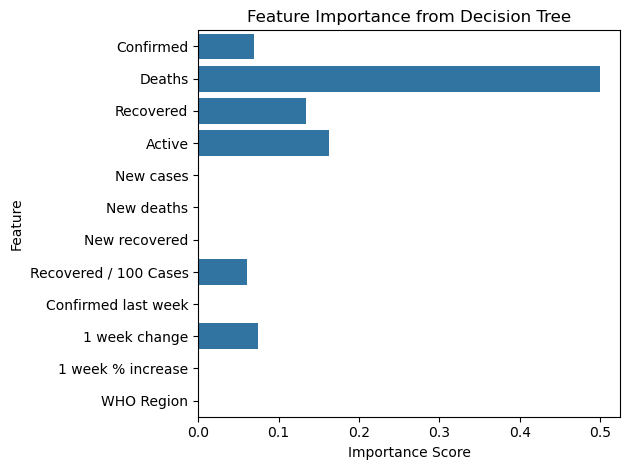

In [52]:
importances = best_model.feature_importances_

# Plot feature importances
sns.barplot(x=importances, y=X.columns)
plt.title("Feature Importance from Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



# This Random Forest verdict tells me the following: 
## Using a Decision Tree, we were able to obtain a .52 f1 score in predicting high fatality rate based on features such as total deaths, active cases, and recovery. Its a little funny that after trying the random forest, and additional hyperparameters and steps, it turns out or original decision tree was the same metrics. From reading online, the best possible alternate model I could use would be something like XGBoost, since it does a better job of handling tabular data. 

## XGBoost is cool, as it basically uses many decision trees in sequence, and focuses on improving them each time. It's kind of 'reinforcement learning adjacent', and seems almost like an evolutionary model. It ISNT though, because the evolutionary algorithms actually introduce mutations. XG Boost just builds the trees in sequence, and uses the feedback and gradient descent from each iteration to improve the next tree. 

## The below block is the final model for this project (I dont know why I did 3, I just kind of kept wanting to make number go up)
## This final model uses XGBoost, with hyperparameter tuning to make a final attempt at increasing our models reliability

In [55]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

class_0_count = (y_train == 0).sum()
class_1_count = (y_train == 1).sum()
scale_weight = class_0_count / class_1_count

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'scale_pos_weight': [scale_weight], 
    'eval_metric': ['logloss'],
    'use_label_encoder': [False]
}

# Initialize the model
xgb = XGBClassifier(random_state=0)

# Grid Search setup
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Run grid search
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Predict and evaluate
y_pred_best_xgb = best_xgb.predict(X_test)

print("\nXGBoost Evaluation Metrics (Tuned Model)")
print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print("Precision:", precision_score(y_test, y_pred_best_xgb))
print("Recall:", recall_score(y_test, y_pred_best_xgb))
print("F1 Score:", f1_score(y_test, y_pred_best_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_xgb))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'colsample_bytree': 1, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'scale_pos_weight': 3.65625, 'subsample': 1, 'use_label_encoder': False}

XGBoost Evaluation Metrics (Tuned Model)
Accuracy: 0.7894736842105263
Precision: 0.6666666666666666
Recall: 0.5454545454545454
F1 Score: 0.6

Confusion Matrix:
 [[24  3]
 [ 5  6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86        27
           1       0.67      0.55      0.60        11

    accuracy                           0.79        38
   macro avg       0.75      0.72      0.73        38
weighted avg       0.78      0.79      0.78        38



C:\Users\Gaming\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:17:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Final Model Comparison and Conclusion

After training multiple models on the COVID-19 dataset to predict high-fatality classification, we evaluated performance based on **F1 Score**, which balances both precision and recall. While at first glance the decision tree and Random Forest algorithms both seemed good based on their accuracy, I was really chasing a higher recall and precision, which intuitively led to training by F1 score in my hyperparameter tuning. 

| Model            | Accuracy | Precision | Recall | F1 Score |
|------------------|----------|-----------|--------|----------|
| Decision Tree    | 76.3%    | 0.625     | 0.45   | 0.53     |
| Random Forest    | 76.3%    | 0.75      | 0.27   | 0.40     |
| **XGBoost**      | **78.9%**| **0.67**  | **0.55**| **0.60** |

**Conclusion:**  
While all three models performed similarly in terms of overall accuracy, **XGBoost outperformed both Decision Tree and Random Forest in F1 Score**, which makes it the most reliable model for our prediction task. XGBoost’s ability to sequentially correct its own errors led to stronger recall and balanced precision. This precision was really important, as the dataset was heavily weighted to begin with. 

